### Load and Prepare Data (MNIST)


In [1]:
### START YOUR CODE ### 
data_home = "./data"
### END YOUR CODE ### 

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml

# in case you have trouble with the fetch_openml, uncomment the following two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

def load_mnist(data_home):
    """
    Loads the mnist dataset, prints the shape of the dataset and 
    returns the array with the images, the array with associated labels 
    and the shape of the images.     
    Parameters: 
    data_home -- Absolute path to the DATA_HOME  
    
    Returns:
    x -- array with images of shape (784,m) where m is the number of images
    y -- array with associated labels with shape (1,m) where m is the number of images
    shape -- (28,28)
    """
    mnist = fetch_openml(name='mnist_784', version=1, cache=True, data_home=data_home)
    x, y = mnist['data'].T, np.array(mnist['target'], dtype='int').T
    m = x.shape[1]
    y = y.reshape(1,m)
    print("Loaded MNIST original:")
    print("Image Data Shape" , x.shape)
    print("Label Data Shape", y.shape)
    return x,y,(28,28)


#### Load and split into train/validation and test set

In [3]:
from sklearn.model_selection import train_test_split

test_size = 10000

x0,y0,shape = load_mnist(data_home)
x, xtest, y, ytest = train_test_split(x0.T, y0.T, test_size=test_size, random_state=1)
x, xtest, y, ytest = x.T, xtest.T, y.T, ytest.T

print("Train/Val Set: (x: %s, y: %s) | Test Set: (x: %s, y: %s)"%(x.shape, y.shape,xtest.shape,ytest.shape))

Loaded MNIST original:
Image Data Shape (784, 70000)
Label Data Shape (1, 70000)
Train/Val Set: (x: (784, 60000), y: (1, 60000)) | Test Set: (x: (784, 10000), y: (1, 10000))


#### Dataset Class

Used to split into train and validation set, normalize and provide batches.

In [4]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

class Dataset(object):
    
    def __init__(self, x, y, val_size, random_state=0):
        """Splits dataset into train and val and normalize the train and val set (min/max normalization).
        
        Parameters:
        x - input features, numpy array of shape(nx,m)
        y - labels, numpy array of shape (1,m)
        """
        xtrain, xval, ytrain, yval = train_test_split(x.T, y.T, test_size=val_size, random_state=random_state)
        self.xtrain = xtrain.T
        self.xval = xval.T
        self.ytrain = ytrain.T
        self.yval = yval.T
        self._normalize()
        
        self.nx = self.xtrain.shape[0]
        self.mtrain = self.xtrain.shape[1]
        self.mval = self.xval.shape[1]
        print("Training Data: x=%s | y=%s, Val Data: x=%s | y=%s"%(str(self.xtrain.shape), str(self.ytrain.shape), 
                                                                    str(self.xval.shape), str(self.yval.shape)))
    
    def normalize(self, x):
        return 2*(x - self.xmin) / (self.xmax - self.xmin) - 1
    
    
    def _normalize(self):
        """Applies min/max-normalization - min and max values computed from the training set.
        Common min and max values for all features are used."""
        self.xmax, self.xmin = np.max(self.xtrain), np.min(self.xtrain)
        self.xtrain = self.normalize(self.xtrain)
        self.xval = self.normalize(self.xval)
            
    def prepare_batches(self, batchsize=None):
        """Initialize training set to provide batches of size batchsize. It reshuffles the samples 
        so that new batches are provided after calling this method. 
        """
        if not batchsize:
            self.batchsize = self.mtrain
        else:
            self.batchsize = batchsize
        self.mb = int(self.mtrain/self.batchsize)
        self.indices = np.arange(self.mtrain)
        np.random.shuffle(self.indices)
        self.counter = 0
      
    def number_of_batches(self):
        """Returns the number of batches. Provides a non-none result only after calling the `prepare_batches`-method.
        
        Returns:
        mb -- number of (complete) batches.  
        """
        return self.mb
    
    def next_batch(self):
        """Provides the next batch. If there are no more batches, the `prepare_batches` is called. 
        
        Returns:
        xbatch -- numpy array of shape (nx,batchsize)
        ybatch -- numpy array of shape (1,batchsize)
        """
        if (self.counter+1) >= self.mb:
            self.prepare_batches(self.batchsize)
        it = self.indices[self.counter*self.batchsize:(self.counter+1)*self.batchsize]
        self.counter += 1
        xbatch = self.xtrain[:,it].reshape(self.nx, self.batchsize)
        ybatch = self.ytrain[:,it].reshape(1,self.batchsize)
        return xbatch, ybatch

In [5]:
ds = Dataset(x, y, val_size=10000)

Training Data: x=(784, 50000) | y=(1, 50000), Val Data: x=(784, 10000) | y=(1, 10000)


### Model

#### Components

In this section, we define the different components of the MLP model, including 

* _Activation function_ including suitable methods to compute values and derivatives: here, the sigmoid activation function will be used. 
* _Softmax activation function_: Here, you just need to provide the possibility to compute the softmax values. The derivatives are needed here but will be implemented in the softmax layer.  
* _Initializer_: For initializing the weights and bias parameters. Here, normally distributed initial values will be provided.
* _Cost Function_ used for training - including suitable methods for computing the values and derivatives: here, the cross-entropy cost will be used.
* _Layer_ : The first core component to be implemented/completed by the students.
* _MLP_ : The second core component to be implemented/completed by the students. Allows to configure an arbitrary number of layers into a sequential structure.  


In [6]:
class ActivationFunction(object):
    """
    Empty parent implementation of all activation functions. All child implementations should implement 
    the two methods defined below.
    """
    def compute_value(self, z):
        """
        Computes the value of the activation function element wise for input array z of arbitrary shape. 
        """
        raise NotImplementedError("To be implemented in the child implementation.")
        
    def compute_derivative(self, z):
        """
        Computes the derivative of the activation function element wise for input array z of arbitrary shape. 
        """
        raise NotImplementedError("To be implemented in the child implementation.")


In [7]:
class SigmoidActivationFunction(ActivationFunction):
        
    def compute_value(self, z):
        return 1.0 / (1.0 + np.exp(-z))
        
    def compute_derivative(self, z):
        s = self.compute_value(z)
        return s * (1 - s)

In [8]:
class SoftmaxActivationFunction(ActivationFunction):
    
    def compute_value(self, z):
        expz = np.exp(z)
        norm = np.sum(expz, axis=0)        
        return expz / norm
        
    def compute_derivative(self, z):
        raise NotImplementedError("Computation of the gradient implemented in the Softmax Layer.")

In [9]:
class NormInitializer(object):
    
    def initialize_weights(self, size, mu=0.0, sigma=1.0):
        return np.random.normal(size=size, loc=mu, scale=sigma)
    
    def initialize_bias(self, size, mu=0.0, sigma=1.0):
        return np.random.normal(size=size, loc=mu, scale=sigma)

In [10]:
class Cost(object):
    
    def compute_value(self, y, prob):
        """
        Computes the value of the cost function for given labels y and predicted probs. 
        
        Arguments:
        y -- labels, a numpy array of shape (1,m)
        prob -- predicted probabilities for the different classes, a numpy array of shape (ny,m)
        
        Returns:
        cost -- a scalar        
        """
        raise NotImplementedError("")
        
    def compute_derivative(self, y, prob):
        """
        Computes the derivative of the cost function w.r.t. predicted probs for given labels y and predicted probs.

        Parameters:
        y -- labels, a numpy array of shape (1,m)
        prob -- predicted probabilities for the different classes, a numpy array of shape (ny,m)
        
        Returns:
        Gradient of cost with respect to the predicted probabilities, a numpy array of shape (ny,m)
        """
        raise NotImplementedError("")         

In [11]:
class CrossEntropy(Cost):

    def compute_value(self, y, prob):
        """
        Computes the value of the cost function for given labels y and predicted probs.
        
        Arguments:
        y -- labels, a numpy array of shape (1,m)
        prob -- predicted probabilities for the different classes, a numpy array of shape (ny,m)
        
        Returns:
        cost -- a scalar
        """
        n, m = prob.shape
        assert(np.max(y) <= n)
        py = prob[y, np.arange(m)]
        J = -np.sum(np.log(py)) / m    
        return J
    
        
    def compute_derivative(self, y, prob):
        """
        Computes the derivative of the cost function w.r.t. predicted probs for given labels y and predicted probs.

        Parameters:
        y -- labels, a numpy array of shape (1,m)
        prob -- predicted probabilities for the different classes, a numpy array of shape (ny,m)
        
        Returns:
        Gradient of cost with respect to the predicted probabilities, a numpy array of shape (ny,m)
        """
        n, m = prob.shape
        result = np.zeros((n, m),dtype=float)
        result[y[0,:], np.arange(m)] = 1.0
        result /= prob
        return -result

In [12]:
class Layer(object):
    
    def __init__(self, layerid, nunits, nunits_prev, activ_func, initializer):
        """
        Instantiates a fully connected layer for an MLP, with given number of input and output activations.
        
        Arguments:
        layerid -- integer id for the layer.
        nunits -- number of units in the given layer.
        nunits_prev -- number of units in the previous layer (= number of input activations).
        activ_func -- activation function to be used (with a `compute_value`- and `compute_derivative`-method).
        initializer -- initializer for the weights and the biases.        
        """
        self.layerid = layerid
        self.nunits = nunits
        self.nunits_prev = nunits_prev
        self.initializer = initializer
        self.activ_func = activ_func
        
        self.weights = None # shape (nunits,nunits_prev)
        self.bias = None # shape (nunits,1)
        self.logits = None # z-values, shape(nunits,m) - will be needed for the backprop part ...
        self.activations = None # shape(nunits,m)
        self.grad_logits = None # grad w.r.t. z, shape(nunits,m) - will be needed as basis for different gradients
        

    def initialize(self):
        """
        Initializes the weights and biases. It uses Xavier normalisation (to be discussed in "regularisation").
        """
        sigmaw = np.sqrt(2.0/(self.nunits+self.nunits_prev)) # suited for sigmoid activation function
        sigmab = np.sqrt(1.0/self.nunits)
        self.weights = self.initializer.initialize_weights(size=(self.nunits,self.nunits_prev), mu=0.0, sigma=sigmaw)
        self.bias = self.initializer.initialize_bias(size=(self.nunits,1), mu=0.0, sigma=sigmab)
        
    
    def propagate(self, activations_prev):
        """
        Computes the activations of the layer given the activations of the previous layer.
        Caches the computed logits (z-values) and activations since the values will be needed 
        when using backpropagation to compute the gradients w.r.t. weigths and biases.

        Arguments:
        activations_prev -- activations of the previous layer (or input layer). A numpy array of shape 
        (nunits_prev,m).
        
        Returns:
        activations -- activations of this layer, a numpy array of shape (nunits,m)
        """
        np.testing.assert_equal(activations_prev.shape[0],self.nunits_prev)
        ### START YOUR CODE ###
        self.logits = self.weights.dot(activations_prev) + self.bias
        self.activations = self.activ_func.compute_value(self.logits)
        ### END YOUR CODE ###
        return self.activations

    
    def backpropagate(self, grad_activations):
        """
        Computes the gradient of the cost w.r.t. to the input activations (activations of the previous 
        layer a^[l-1]) of the given layer. It also computes the gradient w.r.t. the logits (z-values) of 
        the given layer. This will be needed as the basis for computing the gradient of the cost w.r.t. 
        the weights and bias of the given layer. 
        
        The method assumes that the forward propagation (`propagate`) has been invoked for the given mini-batch 
        so that consistent logit-values (self.logits) and activations (self.activations) are available.  
        
        Arguments:
        grad_activations -- gradient of the cost w.r.t. to the output activations of the given layer (a^[l]). 
        A numpy array of shape (nunits_prev,m) 
        
        Returns:
        grad_activations_prev -- gradient of the cost w.r.t. to the input activations of the given layer.
        """
        nsamples = self.logits.shape[1]
        np.testing.assert_equal(grad_activations.shape, (self.nunits, nsamples))

        ### START YOUR CODE ###        
        self.grad_logits = grad_activations * self.activ_func.compute_derivative(self.logits)
        
        # useful for testing the shapes - once self.grad_logits is computed check shape with:
        np.testing.assert_equal(self.grad_logits.shape,(self.nunits,nsamples))
        
        grad_activations_prev = self.weights.T.dot(self.grad_logits)
        
        grad_activations_prev = self.weights.T.dot(self.grad_logits) 
        # useful for testing the shapes - once self.grad_activations_prev is computed check shape with:
        np.testing.assert_equal(grad_activations_prev.shape,(self.nunits_prev,nsamples))        

        return grad_activations_prev
        ### END YOUR CODE ###
    
    
    def gradient_weights(self, activations_prev):
        """
        Computes the gradient of the cost w.r.t. the weights of the given layer and for the given mini-batch.  

        The method assumes that `backpropagate` (and `propagate`) has been invoked for the given mini-batch 
        so that consistent the gradient w.r.t. the logits is available.  

        Arguments:
        activations_prev -- activations of the previous layer (or input layer). A numpy array of shape 
        (nunits_prev,m).
        
        Returns:
        grad_weights -- the gradient w.r.t. to the weights. A numpy array of shape (nunits, nunits_prev).
        """
        ### START YOUR CODE ###
        grad_weights = self.grad_logits.dot(activations_prev.T)
        
        return grad_weights
        ### END YOUR CODE ###
    

    def gradient_bias(self):
        """
        Computes the gradient of the cost w.r.t. the bias of the given layer and for the given mini-batch.  
                
        The method assumes that `backpropagate` (and `propagate`) has been invoked for the given mini-batch 
        so that consistent the gradient w.r.t. the logits is available.  
                
        Returns:
        grad_bias -- the gradient w.r.t. to the bias. A numpy array of shape (nunits, 1).
        """
        ### START YOUR CODE ###        
        grad_bias = self.grad_logits.sum(axis=-1, keepdims=True)
        
        return grad_bias
        ### END YOUR CODE ###


Calculating the derivative of the softmax activation function values $a_i$ with respect to the logits $z_i$ where the layer has $n$ neurons, hence $0\leq i \leq n$, results in

$$
\frac{\partial a_j}{\partial z_i} = \left\{
\begin{array}
\ \sigma(z_i)(1-\sigma(z_j)) \\
-\sigma(z_i)\sigma(z_j) 
\end{array}
\begin{array}
  \quad  \quad  \text{if } i = j\\
 \quad \text{if } i \neq j
\end{array}
\right\}
\sigma(z_i)(\delta_{ij}-\sigma(z_j)) \quad \text{where } \delta_{ij} \text{ describes the Kronecker delta}
$$

In order to get rid of the Kronecker delta in the calculation and vectorize the formula we can reformulate 

$$
\frac{\partial a}{\partial z} = \text{diag}(\sigma(z)) - \sigma(z)\sigma(z)^\top 
$$

This will result in a $n\times n$ matrix.

$$
\left[
\begin{array}
\ \frac{\partial \mathcal a_1}{\partial z_1} & \ldots & \frac{\partial \mathcal a_1}{\partial z_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial \mathcal a_n}{\partial z_1} & \ldots & \frac{\partial \mathcal a_n}{\partial z_n}
\end{array}
\right]
$$

Now to calculate $\frac{\partial \mathcal L}{\partial z_i}$ we simply multiply by the gradient of the loss with respect to the softmax activations. As the change of the logit $z_i$ will influence the softmax activations for all $a_i$, we have to accumulate their gradients

$$
\frac{\partial \mathcal L}{\partial z_i} = \sum_{j=1}^n \frac{\partial \mathcal L}{\partial a_i} \frac{\partial a_j}{\partial z_i}
$$

In a vectorized format this reads as 

$$
\frac{\partial \mathcal L}{\partial z} = \frac{\partial \mathcal L}{\partial a}^\top\cdot \frac{\partial a}{\partial z}= \frac{\partial \mathcal L}{\partial a}^\top\cdot \left( \text{diag}(\sigma(z)) - \sigma(z)\sigma(z)^\top \right)
$$

In [13]:
class Softmax(Layer):

    def __init__(self, layerid, nunits, nunits_prev, initializer):
        """
        Instantiates a Softmax layer with given number of input activations and normalised scores.
        
        Arguments:
        layerid -- integer id for the layer.
        nunits -- number of units in the given layer (=number of classes).
        nunits_prev -- number of units in the previous layer (= number of input activations).
        initializer -- initializer for the weights and the biases.        
        """
        super().__init__(layerid, nunits, nunits_prev, SoftmaxActivationFunction(), initializer)
        
    def backpropagate(self, grad_activations):
        """
        Computes the gradient of the cost w.r.t. to the input activations (activations of the previous 
        layer, activations_prev) of the softmax layer. It also computes the gradient w.r.t. the logits (z-values) of 
        the softmax layer. This will be needed as the basis for computing the gradient of the cost w.r.t. 
        the weights and bias of the layer. 
        
        The method assumes that the forward propagation (`propagate`) has been invoked for the given mini-batch 
        so that consistent logit-values (z-logits) and activations (self.activations) are available.  
        
        Arguments:
        grad_activations -- gradient of the cost w.r.t. to the output activations of the given layer. 
        A numpy array of shape (nunits_prev,m) 
        
        Returns:
        grad_activations_prev -- gradient of the cost w.r.t. to the input activations of the given layer.
        """
        ### START YOUR CODE ###
        m = grad_activations.shape[1]
        # softmax backprpagate helper
        def softmax_back(z, da):
            # great tutorial: https://themaverickmeerkat.com/2019-10-23-Softmax/            
            m, n = z.shape
            tensor1 = np.einsum('ij,ik->ijk', z.T, z.T)
            tensor2 = np.einsum('ji,ik->jik', z.T, np.eye(m,m))
            dSoftmax = tensor2 - tensor1
            dz = np.einsum('ijk,ik->ij', dSoftmax, da.T)
            
            return dz
        
        self.grad_logits = softmax_back(self.activations, grad_activations).T/m
        grad_activations_prev = self.weights.T.dot(self.grad_logits)

        return grad_activations_prev
        
        ### END YOUR CODE ###       

In [14]:
class MLP(object):
    
    def __init__(self, units_per_layer, activ_func, initializer, softmax_as_last_layer=True):
        """
        Instantiates a (fully connected) MLP with architecture specified by the list `units_per_layer` 
        which contains the number of units for the layers (including the input and the output layer).
        It instantiates the Layer-objects and uses layerid=0 for the first hidden layer, layerid=1 
        for the second, etc.
        
        Arguments:
        units_per_layer -- list with the number of units per layers (including the input and the output layer)
        activ_func -- activation function to be used in the different layers except possibly in the output 
        layer (in case softmax_as_last_layer=True)
        initializer -- initializer for the weights and biases of all the layers.
        softmax_as_last_layer -- flag to indicate whether the last layer should be a softmax layer.
        """
        self.layers = [] # list of layers (instances of class Layer or Softmax or the like); ordered along the forward path.
        self.number_of_hidden_layers = None # number of hidden layers (int) (excl. input / sofmax layer)
        self.x = None # input data for one iteration (propagate and backpropagate) 
        
        # Initialize self.layers and self.number_of_hidden_layers
        
        ### START YOUR CODE ###        
        self.number_of_hidden_layers = len(units_per_layer) - 2
        
        for layer_id in range(1, self.number_of_hidden_layers + 1):
            nunits = units_per_layer[layer_id]
            nunits_prev = units_per_layer[layer_id - 1]
            self.layers.append(
                Layer(
                    layer_id, nunits, nunits_prev,
                    SigmoidActivationFunction(), NormInitializer()))
        
        self.layers.append(
            Softmax(
                self.number_of_hidden_layers, units_per_layer[-1],
                units_per_layer[-2], NormInitializer()))
        ### END YOUR CODE ###        

        
    def initialize(self):
        """
        Calls the `initialize`-method of the layers which are used to properly initialize the weights and biases. 
        """
        for layer in self.layers:
            layer.initialize()
    
    def propagate(self, x): 
        """
        Computes the output of the MLP for given input (by using the propagate-method). By executing this method 
        on a given input mini-batch, the activations and the logits of all the layers are computed 
        and cached (consistent with the mini-batch). 
        
        Arguments:
        x -- input of shape (n_0,m)
        
        Returns: 
        a -- activations of the last layer of shape (n_L,m)
        """
        ### START YOUR CODE ###                
        self.x = x
        a = self.x
        
        for layer in self.layers:
            a = layer.propagate(a)
            
        return a
        ### END YOUR CODE ###        

    def backpropagate(self, grady):
        """
        Executes backpropagation for the given MLP (after having executed the `propagate`-method).
        It starts with passing in the gradient of the cost w.r.t. the activations of the last layer 
        (i.e. the input to the cost function) and ends up with the gradient of the cost w.r.t. the 
        input to the first layer (e.g. input x). Once this method has been run, the gradients w.r.t.
        to the logits (z-values) are computed and cached. These will be used to update the weights 
        and biases in accordance with the gradient descent principle. 
        
        Arguments:
        grady -- gradient with respect to the output of the network, i.e. the activations of the last layer
        that is input to the cost function. A numpy array of shape (n_L,m)
        
        Returns:
        gradient with respect to the inputs to the network. A numpy array of shape (n_0,m)
        """
        ### START YOUR CODE ###        
        grad = grady
        
        for layer in reversed(self.layers):
            grad = layer.backpropagate(grad)
        ### END YOUR CODE ###        
    
    def update_params(self, learning_rate):
        """
        Update the weights and biases of all the layers consistent with the gradient descent principle.
        It assumes that the propagate and backpropagate methods have been executed.
        
        Arguments:
        learning_rate -- learning rate to be used in the update rule.   
        """
        ### START YOUR CODE ### 
        prev_activations = self.x

        for layer in self.layers:
            layer.weights -= learning_rate * layer.gradient_weights(prev_activations)
            layer.bias -= learning_rate * layer.gradient_bias()
            
            prev_activations = layer.activations
        ### END YOUR CODE ###        


#### Check the Implementation of Forward Propagation

In [15]:
x00 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,-1.0]).reshape(3,3)
layersizes = [3,10,20,10,5]
np.random.seed(1)
mlp = MLP(layersizes, SigmoidActivationFunction(), NormInitializer(), True)
for layerid in range(len(layersizes)-1):
    layer = mlp.layers[layerid]
    layer.weights = np.ones(shape=(layer.nunits,layer.nunits_prev), dtype='float')*0.1
    layer.bias = np.zeros(shape=(layer.nunits,1), dtype='float')
mlp.initialize()
y00 = mlp.propagate(x00)
np.testing.assert_equal(y00.shape, (5,3))
y00_expected = np.array([
    [0.18559891, 0.18553251, 0.18809197],
    [0.28155687, 0.28171852, 0.27895721],
    [0.05074394, 0.05071549, 0.05141478],
    [0.13742613, 0.13757631, 0.13833757],
    [0.34467414, 0.34445717, 0.34319847]])
np.testing.assert_array_almost_equal(y00, y00_expected, decimal=8)

#### Test Performance of Forward Propagation

Measure the runtimes for propagating all the MNIST training set (60'000 samples) with different batch sizes.

In [16]:
from timeit import default_timer as timer

layersizes = [ds.nx,1000,800,700,600,400,200,100,100,10]
mlp = MLP(layersizes, SigmoidActivationFunction(), NormInitializer(), True)
mlp.initialize()
batchsizes = [1,10,100,1000,10000,50000]
runtimes = {}
nsamples = ds.mtrain

for batchsize in batchsizes:
    start = timer()
    ds.prepare_batches(batchsize)
    for i in range(ds.number_of_batches()):
        xx, yy = ds.next_batch()
        yypred = mlp.propagate(xx)
    end = timer()
    runtime = end-start
    print("Exec time for batchsize %5i : %6.3f sec"%(batchsize,runtime))
    runtimes[batchsize] = runtime

Exec time for batchsize     1 : 51.994 sec
Exec time for batchsize    10 : 15.972 sec
Exec time for batchsize   100 :  9.339 sec
Exec time for batchsize  1000 :  7.894 sec
Exec time for batchsize 10000 : 11.090 sec
Exec time for batchsize 50000 : 22.141 sec


#### Your Explanation of the Observed Runtime vs Batch Size


<font style="color: red;">When using a batch size of 1, all the calculations for the forward passes for every sample in the training set will be executed sequentially. When using a larger batchsize, the calculations can be done in an optimized manner, depending on the hardware of the current machine. The runtime seems to stagnate at ~10s as at some point the hardware cannot handle larger batchsizes anymore and hence runs part of the batches sequentially again. </font>




#### Check the Implementation of the Gradient

For checking the implementation, compute a numeric approximation of the gradient ('numeric gradient') by using the formula as explained in the class. Compare this with the analytic formulas ('analytic gradient') obtained when implementing backprop (or the derivatives of the cross entropy cost).

Actually, do this checking for the cross entropy cost as well as for the MLP model.

When choosing delta0~1.0e-8, we expect a difference of the numeric and the analytic gradient of <= 3.0e-7.  

In [17]:
# Check Gradient of Cross Entropy Cost

ce = CrossEntropy()

y = np.array([0,2]).reshape(1,2)
probs0 = np.array([[0.7,0.1,0.2]]).reshape(1,3).T
J0 = ce.compute_value(y,probs0)

delta0 = 1.0e-8
for i in range(3):
    delta = np.zeros((3,1),dtype='float')
    delta[i,0] = delta0
    probs1 = probs0 + delta
    J1 = ce.compute_value(y,probs1)
    numeric = (J1-J0)/delta0
    analytic = ce.compute_derivative(y,probs0)[i,0]
    d = np.abs(numeric-analytic)
    print(d)

1.1854167203395605e-08
0.0
1.414096573171264e-07


In [18]:
# Check gradient of cost w.r.t. weights and biases of MLP
# An output with a discrepancy is provided only if the difference between numeric and analytic gradient 
# exceeds the accuray of 3.0e-7. Definitely, the difference should not get much larger than this accuracy.

accuracy = 3.0e-7

layersizes = [100,200,300,100,10]
mlp0 = MLP(layersizes, SigmoidActivationFunction(), NormInitializer(), True)
mlp0.initialize()
mlp1 = MLP(layersizes, SigmoidActivationFunction(), NormInitializer(), True)
mlp1.initialize()
for layerid in range(len(layersizes)-1):
    mlp1.layers[layerid].weights = mlp0.layers[layerid].weights.copy()
    mlp1.layers[layerid].bias = mlp0.layers[layerid].bias.copy()

m = 2
x = np.random.uniform(-0.5,0.5,size=(layersizes[0],m))
y = np.random.randint(0,3,size=(1,m))
probs0 = mlp0.propagate(x)
gradJ = ce.compute_derivative(y,probs0)
mlp0.backpropagate(gradJ)
J0 = ce.compute_value(y,probs0)

delta0 = 1.0e-8
for layerid in range(len(layersizes)-1):
    print("Testing layer with id %s"%(layerid))
    if layerid==0:
        activations_prev = x
    else:
        activations_prev = mlp0.layers[layerid-1].activations
    for i in range(layersizes[layerid+1]):
        for j in range(layersizes[layerid]):
            mlp1.layers[layerid].weights[i,j]+=delta0
            probs1 = mlp1.propagate(x)
            J1 = ce.compute_value(y,probs1)
            numeric = (J1-J0)/delta0
            analytic = mlp0.layers[layerid].gradient_weights(activations_prev)[i,j]
            d = np.abs(numeric-analytic)
            if d > accuracy:
                print("Layer %i (%i,%i)"%(layerid,i,j), d, numeric, analytic)
            mlp1.layers[layerid].weights[i,j]-=delta0


Testing layer with id 0
Testing layer with id 1
Testing layer with id 2
Testing layer with id 3


#### Metrics Class

For not littering the optimization loop with code to keep track of the learning results over the epochs we defined a suitable metrics object that keeps all the data (cost function, classification error vs epochs). It also provides utility methods for updating, printing values or plotting the learning curves.

It is defined as python class the metrics object then needs to be instantiated from. It means that some small knowledge about object-oriented programming is needed here.  

In [19]:
import matplotlib.pyplot as plt

class Metrics():
    """
    Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
    and for creating learning curves that are a useful tool for analyzing the quality of the learning.
    """
    
    def __init__(self, cost):
        """
        Constructor for a metrics object. 
        Initializes all the statistics to track in form of python lists.
        
        Parameters:
        cost -- cost function to use (a python function)
        """
        self.epochs = []
        self.train_costs_last = []
        self.val_costs_last = []
        self.train_errors_last = []
        self.val_errors_last = []

        self.cost = cost
        self.init_epoch()

            
    def init_epoch(self):
        self.train_costs_epoch = []
        self.val_costs_epoch = []
        self.train_errors_epoch = []
        self.val_errors_epoch = []
        
        
    def update_epoch(self, epoch):
        """
        Computes the average of the metrics over the epoch and adds the result to the per epoch history
        
        Parameters:
        epoch -- the epoch to add to the per epoch cache
        """
        self.epochs.append(epoch)
        self.train_costs_last.append(self.train_costs_epoch[-1])
        self.val_costs_last.append(self.val_costs_epoch[-1])
        self.train_errors_last.append(self.train_errors_epoch[-1])
        self.val_errors_last.append(self.val_errors_epoch[-1])
        
        self.init_epoch()
    
    def error_rate(self, y, probs):
        m = y.shape[1]
        ypred = np.argmax(probs, axis=0).reshape(1,m)
        rate = np.sum(y != ypred) / m
        return rate        
        
    def update_iteration(self, ypred_train, y_train, ypred_val, y_val):
        """
        Allows to update the statistics to be tracked for a new epoch.
        The cost is computed by using the function object passed to the constructor.
        
        Parameters:
        epoch -- Epoch
        ypred_train -- predicted values on the training samples, a numpy array of shape (1,m1)
        y_train -- ground truth labels associated with the training samples, a numpy array of shape (1,m1)
        ypred_val -- predicted values on the val samples, a numpy array of shape (1,m2)
        y_val -- ground truth labels associated with the val samples, a numpy array of shape (1,m2)
        """
        Jtrain = self.cost.compute_value(y_train, ypred_train)
        Jval = self.cost.compute_value(y_val, ypred_val)
        train_error = self.error_rate(y_train, ypred_train)
        val_error = self.error_rate(y_val, ypred_val)

        self.train_costs_epoch.append(Jtrain)
        self.val_costs_epoch.append(Jval)
        self.train_errors_epoch.append(train_error)
        self.val_errors_epoch.append(val_error)
        
        
    def print_latest_errors(self):
        print ("Train/val error after epoch %i: %f, %f" %(self.epochs[-1], self.train_errors_last[-1], self.val_errors_last[-1]))

    def print_latest_costs(self):
        print ("Train/val cost after epoch %i: %f, %f" %(self.epochs[-1], self.train_costs_last[-1], self.val_costs_last[-1]))

    def plot_cost_curves(self, xrange=None, yrange=None, logscale=True):
        if logscale:
            plt.semilogy(self.epochs, self.train_costs_last, "b-", label="train")
            plt.semilogy(self.epochs, self.val_costs_last, "r-", label="val")
        else:
            plt.plot(self.epochs, self.train_costs_last, "b-", label="train")
            plt.plot(self.epochs, self.val_costs_last, "r-", label="val")            
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        if not xrange:
            xrange=(0,self.epochs[-1])
        if not yrange:
            ymin = min(max(1e-5,np.min(self.train_costs_last)),max(1e-5,np.min(self.val_costs_last))) * 0.8
            ymax = max(np.max(self.train_costs_last),np.max(self.val_costs_last)) * 1.2
            yrange = (ymin,ymax)
        plt.axis([xrange[0],xrange[1],yrange[0],yrange[1]])
        plt.legend()
        plt.show()        
    
    def plot_error_curves(self, xrange=None, yrange=None, logscale=True):
        if logscale:
            plt.semilogy(self.epochs, self.train_errors_last, "b-", label="train")
            plt.semilogy(self.epochs, self.val_errors_last, "r-", label="val")
        else:
            plt.plot(self.epochs, self.train_errors_last, "b-", label="train")
            plt.plot(self.epochs, self.val_errors_last, "r-", label="val")            
        plt.ylabel('Errors')
        plt.xlabel('Epochs')
        if not xrange:
            xrange=(0,self.epochs[-1])
        if not yrange:
            ymin = min(max(1e-5,np.min(self.train_errors_last)),max(1e-5,np.min(self.val_errors_last))) * 0.8
            ymax = max(np.max(self.train_errors_last),np.max(self.val_errors_last)) * 1.2
            yrange = (ymin,ymax)
        plt.axis([xrange[0],xrange[1],yrange[0],yrange[1]])        
        plt.legend()
        plt.show()

### Training, Evaluating Performance

In [20]:
def optimize(mlp, cost, ds, nepochs, learning_rate, batchsize=32, debug=True):
    """
    
    Arguments:
    mlp -- instance of MLP
    cost -- instance of cost function to be used.
    ds -- instance of Dataset class
    nepochs -- number of epochs (sweeps through the training dataset in the optimization loop)
    learning_rate -- learning rate of the gradient descent update rule
    batchsize -- batch size, defaults to 32
    debug -- if true prints training and test error values after each epoch. Defaults to True.
    
    Returns:
    metrics -- contain the information about the learning curves
    """ 
    mlp.initialize()
    metrics = Metrics(cost = cost)
    ds.prepare_batches(batchsize)
    
    # compute and set the initial values for the metrics curves
    ypred_train = mlp.propagate(ds.xtrain)    
    ypred_val = mlp.propagate(ds.xval)    
    metrics.update_iteration(ypred_train, ds.ytrain, ypred_val, ds.yval)
    metrics.update_epoch(0)
    
    # Loop over the epochs    
    for i in range(nepochs):
                
        batches = ds.prepare_batches(batchsize)
        
        ### START YOUR CODE ### 
        # Loop over the batches: 
        # propagate and then back-propagate the gradient of the cost
        # update the parameters by using the gradient of the costs w.r.t. these parameters and the learning rate
        # finally update the metrics object
        
        for j in range(ds.mb):
            xbatch, ybatch = ds.next_batch()
            ypred = mlp.propagate(xbatch)
            
            J0 = cost.compute_derivative(ybatch, ypred)
            mlp.backpropagate(J0)
            
            mlp.update_params(learning_rate)
            
            
        ypred_train = mlp.propagate(ds.xtrain)    
        ypred_val = mlp.propagate(ds.xval)    
        metrics.update_iteration(ypred_train, ds.ytrain, ypred_val, ds.yval)
        metrics.update_epoch(i)
        ### END YOUR CODE ### 
            
        if debug:
            metrics.print_latest_errors()
        
    metrics.print_latest_costs()
    metrics.print_latest_errors()

    return metrics    

In [21]:
from timeit import default_timer as timer

### START YOUR CODE ### 
learning_rate = 0.01
batchsize = 64
nepochs = 200
layersizes = (784, 780, 10)
### END YOUR CODE ### 

mlp = MLP(layersizes, SigmoidActivationFunction(), NormInitializer(), True)
ce = CrossEntropy()

start = timer()
metrics = optimize(mlp, ce, ds, nepochs, learning_rate, batchsize=batchsize, debug=True)
end = timer()
lapsetime = end-start
print(lapsetime)


Train/val error after epoch 0: 0.157900, 0.153100
Train/val error after epoch 1: 0.128700, 0.125400
Train/val error after epoch 2: 0.118340, 0.116300
Train/val error after epoch 3: 0.109800, 0.108500
Train/val error after epoch 4: 0.104460, 0.105100
Train/val error after epoch 5: 0.103080, 0.101200
Train/val error after epoch 6: 0.098380, 0.098600
Train/val error after epoch 7: 0.094360, 0.095100
Train/val error after epoch 8: 0.092400, 0.091300
Train/val error after epoch 9: 0.091700, 0.091000
Train/val error after epoch 10: 0.089860, 0.089400
Train/val error after epoch 11: 0.089760, 0.088600
Train/val error after epoch 12: 0.087460, 0.087800
Train/val error after epoch 13: 0.086340, 0.086900
Train/val error after epoch 14: 0.084620, 0.084600
Train/val error after epoch 15: 0.084180, 0.082800
Train/val error after epoch 16: 0.082700, 0.082500
Train/val error after epoch 17: 0.082280, 0.080500
Train/val error after epoch 18: 0.081780, 0.082400
Train/val error after epoch 19: 0.079820,

Train/val error after epoch 160: 0.023260, 0.032500
Train/val error after epoch 161: 0.023320, 0.033400
Train/val error after epoch 162: 0.022520, 0.032000
Train/val error after epoch 163: 0.022940, 0.032700
Train/val error after epoch 164: 0.022720, 0.033300
Train/val error after epoch 165: 0.022340, 0.032100
Train/val error after epoch 166: 0.022380, 0.033000
Train/val error after epoch 167: 0.022060, 0.031900
Train/val error after epoch 168: 0.021900, 0.031600
Train/val error after epoch 169: 0.022420, 0.032000
Train/val error after epoch 170: 0.022380, 0.031400
Train/val error after epoch 171: 0.021500, 0.031400
Train/val error after epoch 172: 0.021760, 0.032400
Train/val error after epoch 173: 0.021040, 0.030900
Train/val error after epoch 174: 0.021040, 0.031200
Train/val error after epoch 175: 0.021000, 0.030900
Train/val error after epoch 176: 0.021460, 0.031900
Train/val error after epoch 177: 0.020860, 0.030500
Train/val error after epoch 178: 0.020240, 0.030800
Train/val er

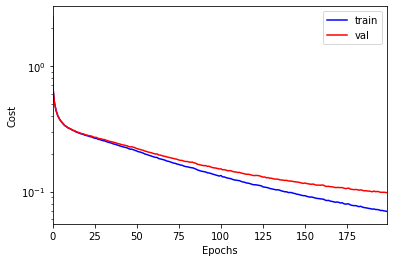

In [22]:
metrics.plot_cost_curves()

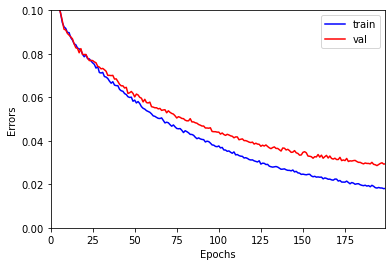

Train/val error after epoch 199: 0.018120, 0.029400


In [23]:
metrics.plot_error_curves(yrange=(0,0.1), logscale=False)
metrics.print_latest_errors()

### Evaluation Results



TODO: 
- Describe here your findings on the best hyper parameter settings for the two architectures and the resulting validation error.
- Choose your best model



### Performance of the final model on test dataset

In [24]:
### START YOUR CODE ### 
ypred = mlp.propagate(xtest)
error = (np.argmax(ypred, axis=0) != ytest).sum() / ypred.size
### END YOUR CODE ### 
print("Test error: ", error)

Test error:  0.01715


<ipython-input-7-482fd3ffdbda>:4: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
